In [1]:
import torch
import torch.nn as nn
from est_lib.util.obspy_util import *
from est_lib.dataset.seismic_dataset import CNDataset
from obspy import UTCDateTime as dt
from torch.utils.data import DataLoader

In [2]:
from torch_geometric_temporal.nn.attention import MTGNN

In [3]:
import os
from tqdm.notebook import tqdm

In [4]:
# Env Stuff
inv_file_name = 'inv.xml'
str_file_name = 'str.pkl'
file_path = os.path.abspath('../est_lib/_data/')
sta_list = ['HOLB','BFSB','CBB']

def check_files():
    contents = os.listdir(file_path)
    if inv_file_name not in contents:
        inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')
        # Save File
        f_path = os.path.join(file_path,inv_file_name)
        op_file_path = inventory_writer(inv,
                                    f_path,
                                    file_format="STATIONXML")
    if str_file_name not in contents:
        stream = stream_retriever(event_time = dt('2019-12-25T03:36:01.578000Z'),
                              seconds_before = 600,
                              seconds_after = 1500,
                              network="CN",
                              sta_list=sta_list,
                              channel_list=['HHE'])
        f_path = os.path.join(file_path,str_file_name)
        op_file_path = stream_writer(stream,
                                 f_path,
                                 file_format="PICKLE")
    print(file_path)
    print(os.listdir(file_path))

In [5]:
# Retrieve Stream and Inventory
check_files()

C:\Users\aksha\Desktop\eew-spatio-temporal\est_lib\_data
['inv.xml', 'str.pkl']


In [6]:
# Set Up Dataset Object
obj = CNDataset(os.path.join(file_path,inv_file_name),
                os.path.join(file_path,str_file_name),
                    sta_list=sta_list,
                    ip_dim=1,
                    num_nodes=3,
                    seq_length=101) # Logical Bug with length

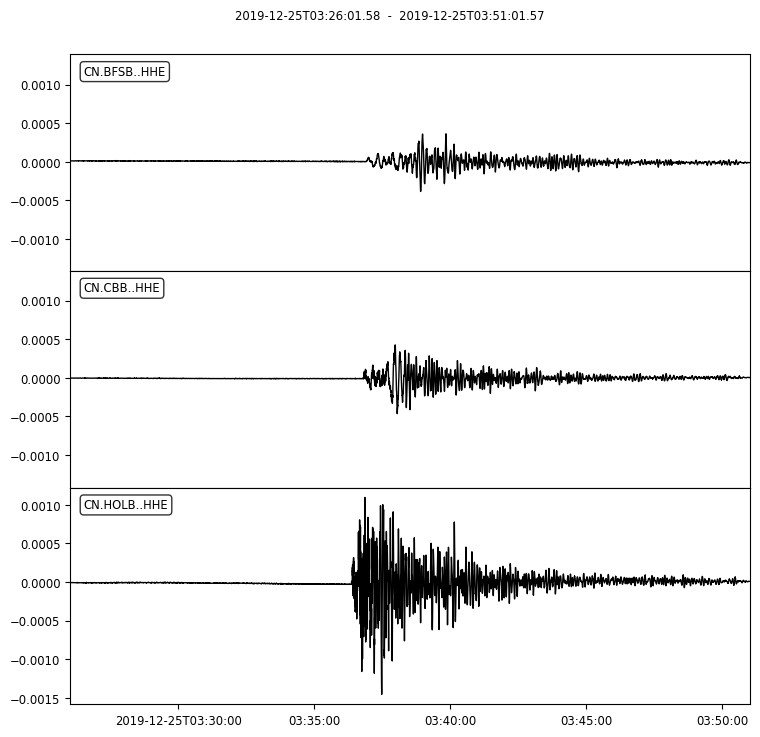

In [7]:
# View Streams
op = obj.stream.plot()

In [8]:
print(obj.stream)

3 Trace(s) in Stream:
CN.BFSB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples
CN.CBB..HHE  | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples
CN.HOLB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples


In [ ]:
# Set Up Dataloader
proto_batch_size = 20
train_loader = DataLoader(obj,batch_size=proto_batch_size,shuffle=False)

In [ ]:
'''
#feat, lab = next(iter(train_loader))
print(feat.shape)
print(lab.shape)
'''

In [ ]:
# Set Up CUDA
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
obj.data = obj.data.to(device)
obj.labels = obj.labels.to(device)

In [ ]:
print(obj.data.device)
print(obj.labels.device)

In [ ]:
# Set Up Model
gcn_true = True
build_adj = True
dropout = 0.3
subgraph_size = 3
gcn_depth = 2
num_nodes = obj.num_nodes # Important
node_dim = 1 # Need to verify from Paper
dilation_exponential = 1
conv_channels = 32
residual_channels = 32
skip_channels = 64
end_channels = 128
in_dim = obj.ip_dim # Important
seq_in_len = obj.seq_length-1 # Important # seq-len bug to be adressed
seq_out_len = 1
layers = 3
batch_size = proto_batch_size # Set by Data Loader
propalpha = 0.05
tanhalpha = 3
num_split = 1
kernel_size = 7
kernel_set = [2, 3, 6, 7]

In [ ]:
model = MTGNN(gcn_true=gcn_true, build_adj=build_adj, gcn_depth=gcn_depth, num_nodes=num_nodes,
                kernel_size=kernel_size, kernel_set=kernel_set, dropout=dropout, subgraph_size=subgraph_size,
                node_dim=node_dim, dilation_exponential=dilation_exponential,
                conv_channels=conv_channels, residual_channels=residual_channels,
                skip_channels=skip_channels, end_channels=end_channels,
                seq_length=seq_in_len, in_dim=in_dim, out_dim=seq_out_len,
                layers=layers, propalpha=propalpha, tanhalpha=tanhalpha, layer_norm_affline=True)
#model.double()
model.to(device)

In [ ]:
# Train Param
criterion = nn.MSELoss(size_average=False)
evaluateL2 = nn.MSELoss(size_average=False)
evaluateL1 = nn.L1Loss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
# Train Loop
losses = list()
epochs = 1
model.train() # Train Mode
for e in tqdm(range(epochs)):
    for bid, samp in tqdm(enumerate(train_loader)):
        model.zero_grad()
#        if bid == 1:
#           break
        x = samp[0]
        y = torch.unsqueeze(samp[1],3) # or squeeze op
        # cuda stuff goes here
        op = model(x.float())
        loss = criterion(op,y.float())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

In [ ]:
print(losses)

In [ ]:
len(losses)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.show()

In [ ]:
adj = model._graph_constructor(model._idx.to(device)).detach().cpu().numpy()
print(adj)

In [ ]:
op

In [ ]:
# Eval Loop
test_loader = DataLoader(obj,batch_size=40,shuffle=False)
loss_eval = list()
op_eval = list()
model.eval()
for e in tqdm(range(epochs)):
    for bid, samp in tqdm(enumerate(test_loader)):
#        if bid == 1:
#           break
        x = samp[0]
        # cuda stuff goes here
        op = model(x.float())
        op_eval.append(op.detach().cpu())
        y = torch.unsqueeze(samp[1],3) # or squeeze op
        loss = criterion(op,y.float())
        loss_eval.append(loss.item())
        del loss

In [ ]:
op_eval

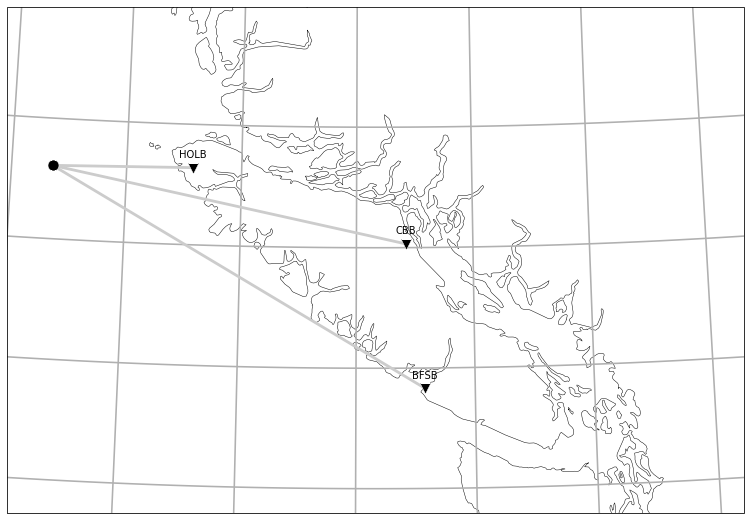

In [9]:
from est_lib.util.obspy_plot import ray_plot
import numpy as np
# Plot
lat = 50.6081
lon = -129.9656
ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=obj.stream,
    inventory=obj.inv)

In [10]:
adj_mat = np.array([[0,1,1],[0,0,0.6],[0,0,0]])

1.0
1.0
0.0
0.6
0.0
0.0


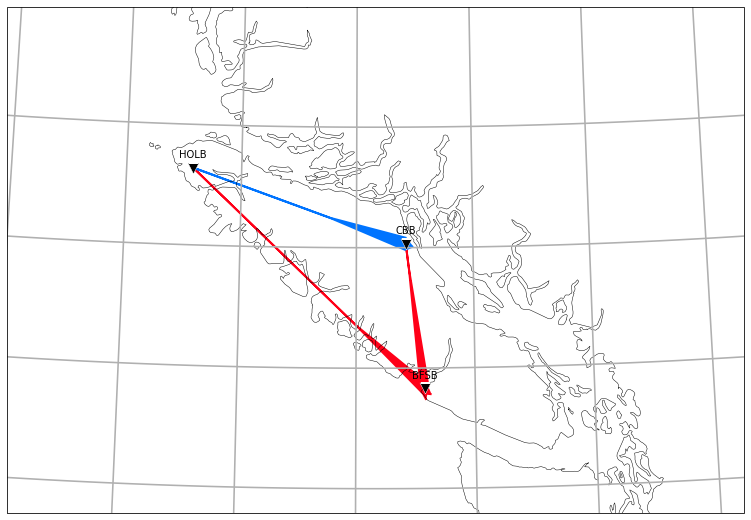

In [11]:
from est_lib.util.obspy_plot import adj_plot
adj_plot(
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=obj.stream,
    inventory=obj.inv,
    adj_mat=adj_mat)